# before projection head

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random


from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import functional as Func

In [2]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_2620\3495648145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [5]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [6]:

# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))

    print(image.shape)
    image_to_model = image.unsqueeze(0)
    print(image_to_model.shape)
    
    return image,image_to_model


In [8]:
def R_Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    # Create a rotated version of the image (90 degrees clockwise)
    rotated_image = torch.rot90(image, k=1, dims=(1, 2))  # Rotate along height and width dimensions
    
    # Add batch dimension to both images
    image_to_model = image.unsqueeze(0)
    rotated_image_to_model = rotated_image.unsqueeze(0)
    
    # Print shapes for debugging
    print("Original image shape:", image.shape)
    print("Original image to model shape:", image_to_model.shape)
    print("Rotated image shape:", rotated_image.shape)
    print("Rotated image to model shape:", rotated_image_to_model.shape)
    
    return image, image_to_model, rotated_image, rotated_image_to_model


In [9]:
import matplotlib.pyplot as plt

def display_image(image_tensor, title="Image", cmap="gray", figsize=(5, 5)):

    # Convert PyTorch tensor to NumPy array and adjust shape for plotting
    image_np = image_tensor.numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)

    # Display the image
    plt.figure(figsize=figsize)
    plt.imshow(image_np, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Turn off axis for cleaner visualization
    plt.show()


In [10]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [11]:
# first control day 1 to day 2

path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\RBT_01.04_B02-T01.tiff'
first_cd1,first_cd1_to_model = Preprocess_Image(path_of_image)


# Example usage
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(first_cd1, title="First Image")


In [13]:
R_path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\RBT_01.04_B02-T01.tiff'
cd1_im,cd1_model, cd2_im, cd2_model = R_Preprocess_Image(R_path_of_image)

Original image shape: torch.Size([3, 96, 96])
Original image to model shape: torch.Size([1, 3, 96, 96])
Rotated image shape: torch.Size([3, 96, 96])
Rotated image to model shape: torch.Size([1, 3, 96, 96])


In [14]:
cd1 = extract_features(simclr_model, cd1_model)
cd2 = extract_features(simclr_model, cd2_model)
print(cd1.shape)
print(cd2.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [15]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(cd1, cd2, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8565492630004883


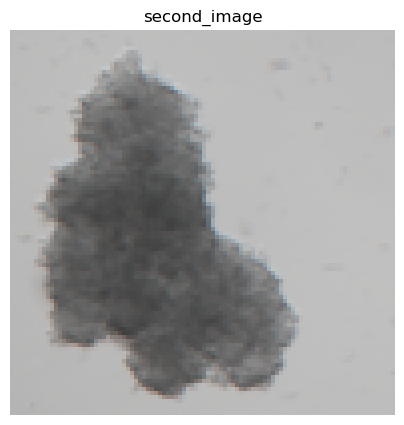

In [16]:
display_image(cd2_im, title="second_image")

In [15]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\day10\RBT_01.04_B02-T01.tiff'
first_cd2, first_cd2_to_model = Preprocess_Image(pathimage)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


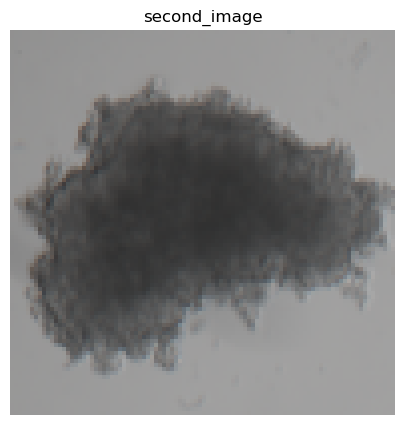

In [16]:
display_image(first_cd2, title="second_image")

In [17]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, first_cd1_to_model)
second_image_feats = extract_features(simclr_model, first_cd2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [18]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.3846457302570343


In [ ]:
#second control d1 and d2

In [16]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\day7\RBT_01.04_B04-T01.tiff'
second_cd1,second_cd1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


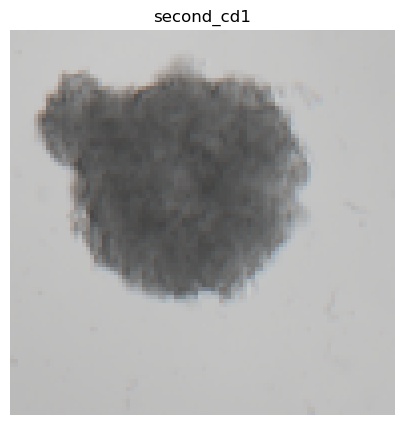

In [17]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_cd1, title="second_cd1")


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


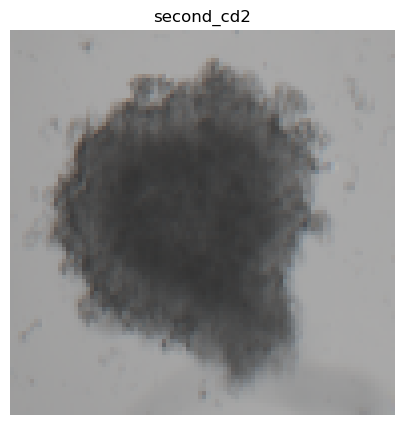

In [13]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\day10\RBT_01.04_B04-T01.tiff'
second_cd2, second_cd2_to_model = Preprocess_Image(pathimage)
display_image(second_cd2, title="second_cd2")

In [37]:
# Extract features for both images
first_feats = extract_features(simclr_model, second_cd1_to_model)
second_feats = extract_features(simclr_model, second_cd2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [38]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_feats, second_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.28842267394065857


In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt

In [2]:
p = r'C:\Users\k54739\Bibi_new_thesis\RBT_01.04_B04-T01.tiff'
image = tiff.imread(p)

In [5]:
import numpy as np
import torch
import tifffile as tiff
from torchvision import transforms

# Load the image
p = r'C:\Users\k54739\Bibi_new_thesis\RBT_01.04_B04-T01.tiff'
image = tiff.imread(p)

# Normalize the image to the range [0, 1] and convert it to a PyTorch tensor
image = image.astype(np.float32) / 65535.0  # Assuming 16-bit TIFF image
image = torch.tensor(image, dtype=torch.float32)
image = TF.resize(image, (96, 96))
# Add channel dimension if it's a grayscale image (H, W -> 1, H, W)
if len(image.shape) == 2:  # Grayscale image
    image = image.unsqueeze(0)

# Define transformations
data_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=1),  # Randomly flip horizontally
    #transforms.RandomVerticalFlip(p=1),    # Randomly flip vertically
    transforms.RandomRotation(degrees=(360),expand = True)  # Randomly rotate between 0 to 360 degrees
])

# Apply the transformations
transformed_image = data_transforms(image)

# For visualization or saving, you may need to convert back to NumPy
transformed_image_np = transformed_image.squeeze(0).numpy()  # Remove channel dim if grayscale

# Print or display the transformed image
print(f"Original Shape: {image.shape}")
print(f"Transformed Shape: {transformed_image.shape}")


Original Shape: torch.Size([3, 96, 96])
Transformed Shape: torch.Size([3, 106, 106])


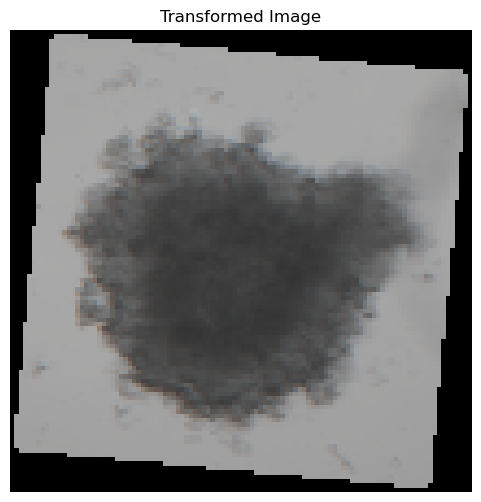

In [6]:

# Transpose the image from (C, H, W) -> (H, W, C)
transformed_image_np = transformed_image_np.transpose(1, 2, 0)

# Visualize the image
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_np)
plt.title("Transformed Image")
plt.axis("off")
plt.show()

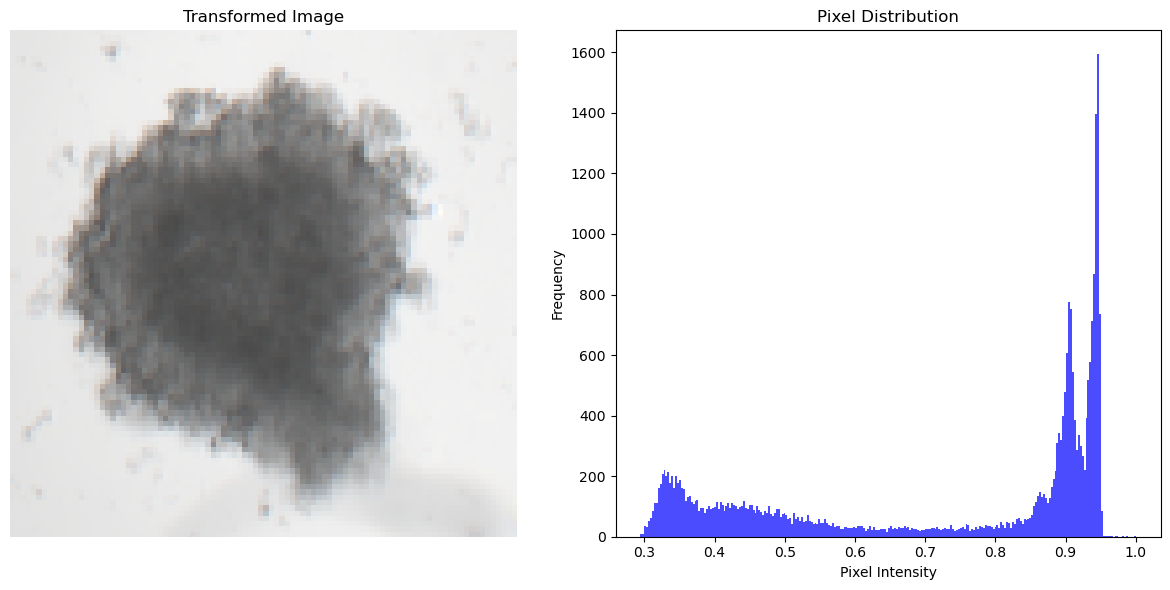

In [13]:
import matplotlib.pyplot as plt

# Transpose the image to (H, W, C) for visualization
transformed_image_np = transformed_image_np.transpose(1, 2, 0)

# Ensure pixel values are scaled properly for visualization
if transformed_image_np.dtype == "float32" or transformed_image_np.dtype == "float64":
    # Normalize to range [0, 1] for proper display
    transformed_image_np = transformed_image_np / transformed_image_np.max()

# Visualize the image
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(transformed_image_np)
plt.title("Transformed Image")
plt.axis("off")

# Plot the pixel distribution
plt.subplot(1, 2, 2)
plt.hist(transformed_image_np.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Pixel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
black_pixel_count = (transformed_image_np == 0).sum()
print(f"Number of black pixels: {black_pixel_count}")


Number of black pixels: 6048


In [14]:
transformed_image.shape
pre_transformed_image = transformed_image.unsqueeze(0)
print(pre_transformed_image.shape)

torch.Size([1, 3, 96, 96])


In [18]:
transformed_image_feats = extract_features(simclr_model, pre_transformed_image)
first_feats = extract_features(simclr_model, second_cd1_to_model)
print(transformed_image_feats.shape)
print(first_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [19]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_feats, transformed_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.33035075664520264


In [ ]:
#first sd

In [24]:
path_of_imge = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61\B11-T01.tiff'
first_sd1,first_sd1_to_model = Preprocess_Image(path_of_imge)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


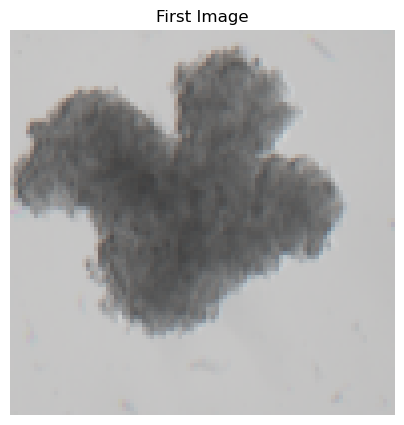

In [25]:
display_image(first_sd1, title="First Image")

In [27]:
pathimag = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61\B11-T01.tiff'
first_sd2, first_sd2_to_model = Preprocess_Image(pathimag)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


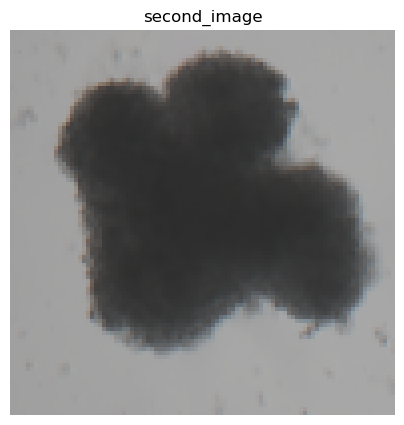

In [28]:
display_image(first_sd2, title="second_image")

In [29]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, first_sd1_to_model)
second_image_feats = extract_features(simclr_model, first_sd2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [30]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.36504146456718445


In [20]:
p = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61\B11-T01.tiff'
image = tiff.imread(p)

# Normalize the image to the range [0, 1] and convert it to a PyTorch tensor
image = image.astype(np.float32) / 65535.0  # Assuming 16-bit TIFF image
image = torch.tensor(image, dtype=torch.float32)
image = TF.resize(image, (96, 96))

# Add channel dimension if it's a grayscale image (H, W -> 1, H, W)
if len(image.shape) == 2:  # Grayscale image
    image = image.unsqueeze(0)

# Define transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=1),   # Randomly flip vertically
    #transforms.RandomRotation(degrees=(360))  # Randomly rotate between 0 to 360 degrees
])

# Apply the transformations
transformed_image = data_transforms(image)

# For visualization or saving, you may need to convert back to NumPy
transformed_image_np = transformed_image.squeeze(0).numpy()  # Remove channel dim if grayscale

# Print or display the transformed image
print(f"Original Shape: {image.shape}")
print(f"Transformed Shape: {transformed_image.shape}")


Original Shape: torch.Size([3, 96, 96])
Transformed Shape: torch.Size([3, 96, 96])


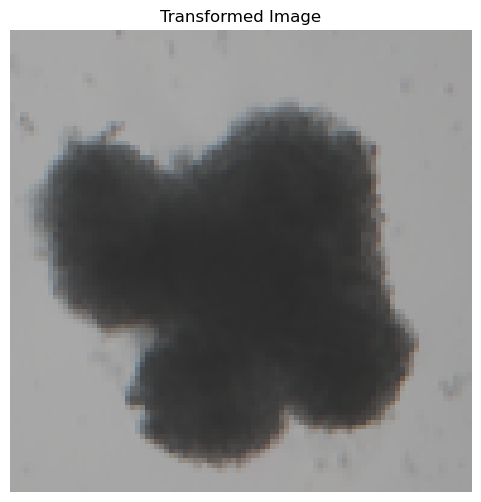

In [21]:

# Transpose the image from (C, H, W) -> (H, W, C)
transformed_image_np = transformed_image_np.transpose(1, 2, 0)

# Visualize the image
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_np)
plt.title("Transformed Image")
plt.axis("off")
plt.show()

In [22]:
transformed_image.shape
pre_transformed_image = transformed_image.unsqueeze(0)
print(pre_transformed_image.shape)

torch.Size([1, 3, 96, 96])


In [26]:
transformed_image_feats = extract_features(simclr_model, pre_transformed_image)
first_feats = extract_features(simclr_model, first_sd1_to_model)
print(transformed_image_feats.shape)
print(first_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [27]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_feats, transformed_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.3360106647014618


In [ ]:
#second sd 1 and sd2 

In [42]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61\B08-T01.tiff'
second_sd1,second_sd1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


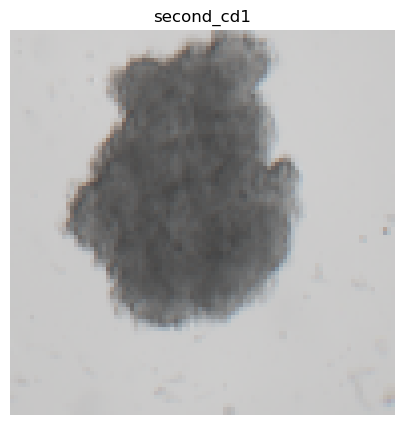

In [43]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_sd1, title="second_cd1")


In [48]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61\B08-T01.tiff'
second_sd2,second_sd2_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


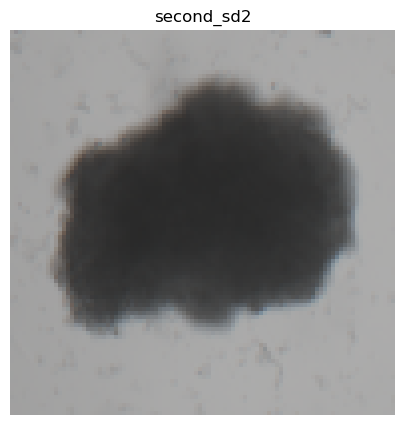

In [49]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_sd2, title="second_sd2")


In [28]:
# Extract features for both images
first_feats = extract_features(simclr_model, second_sd1_to_model)
second_feats = extract_features(simclr_model, second_sd2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

NameError: name 'second_sd1_to_model' is not defined

In [53]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_feats, second_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.29428642988204956


In [38]:
p = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61\B08-T01.tiff'
image = tiff.imread(p)

# Normalize the image to the range [0, 1] and convert it to a PyTorch tensor
image = image.astype(np.float32) / 65535.0  # Assuming 16-bit TIFF image
image = torch.tensor(image, dtype=torch.float32)
image = TF.resize(image, (96, 96))

# Add channel dimension if it's a grayscale image (H, W -> 1, H, W)
if len(image.shape) == 2:  # Grayscale image
    image = image.unsqueeze(0)

# Define transformations
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=[90, 90]), 
    #transforms.RandomHorizontalFlip(p=1),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=1),   # Randomly flip vertically
    #transforms.RandomRotation(degrees=(360))  # Randomly rotate between 0 to 360 degrees
])

# Apply the transformations
transformed_image = data_transforms(image)

# For visualization or saving, you may need to convert back to NumPy
transformed_image_np = transformed_image.squeeze(0).numpy()  # Remove channel dim if grayscale

# Print or display the transformed image
print(f"Original Shape: {image.shape}")
print(f"Transformed Shape: {transformed_image.shape}")


Original Shape: torch.Size([3, 96, 96])
Transformed Shape: torch.Size([3, 96, 96])


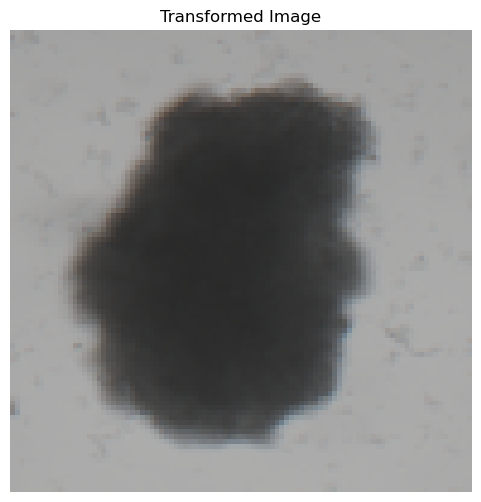

In [39]:

# Transpose the image from (C, H, W) -> (H, W, C)
transformed_image_np = transformed_image_np.transpose(1, 2, 0)

# Visualize the image
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_np)
plt.title("Transformed Image")
plt.axis("off")
plt.show()

In [40]:
transformed_image.shape
pre_transformed_image = transformed_image.unsqueeze(0)
print(pre_transformed_image.shape)

torch.Size([1, 3, 96, 96])


In [44]:
transformed_image_feats = extract_features(simclr_model, pre_transformed_image)
first_feats = extract_features(simclr_model, second_sd1_to_model)
print(transformed_image_feats.shape)
print(first_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [45]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_feats, transformed_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.28209739923477173


In [ ]:
exploded first

In [54]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day7\ds_1b_gp9_C7.tiff'
first_ed1,first_ed1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


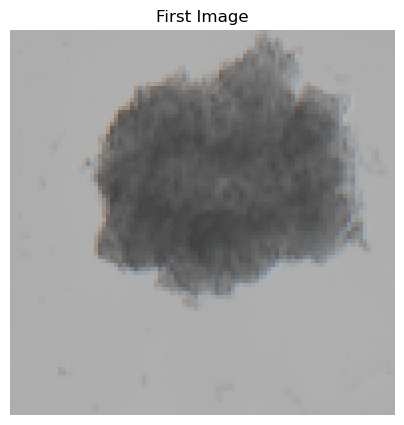

In [55]:

# Example usage
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(first_ed1, title="First Image")


In [56]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day10\ds_1b_gp9_C7.tiff'
first_ed2,first_ed2_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


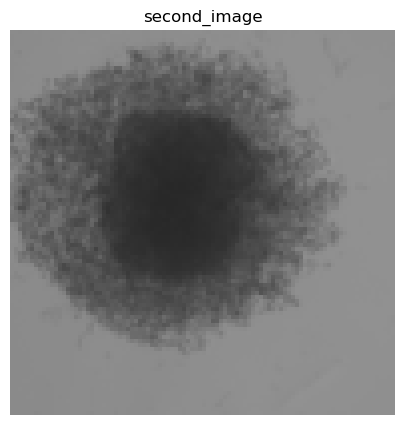

In [58]:
display_image(first_ed2, title="second_image")

In [59]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, first_ed1_to_model)
second_image_feats = extract_features(simclr_model, first_ed2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [60]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.27455416321754456


In [ ]:
#second exploded d1 and d2

In [61]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day7\ds_1b_gp9_C8.tiff'
second_ed1,second_ed1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


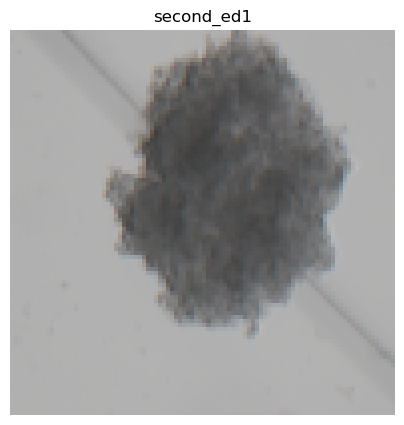

In [63]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_ed1, title="second_ed1")


In [64]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day10\ds_1b_gp9_C8.tiff'
second_ed2,second_ed2_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


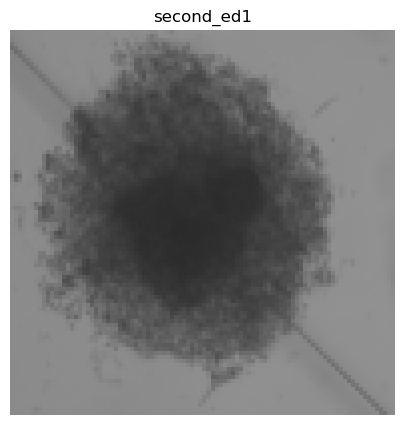

In [65]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_ed2, title="second_ed1")


In [66]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, second_ed1_to_model)
second_image_feats = extract_features(simclr_model, second_ed2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [67]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.2791292369365692


In [ ]:
#less exploded
first

In [68]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day7\ds_6.2_gp9_C09-T01.tiff'
first_led1,first_led1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


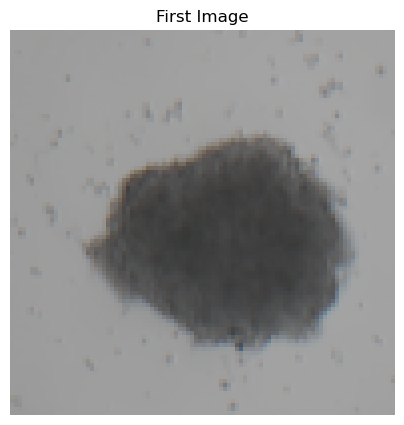

In [69]:

# Example usage
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(first_led1, title="First Image")


In [70]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day10\ds_6.2_gp9_C09-T01.tiff'
first_led2,first_led2_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


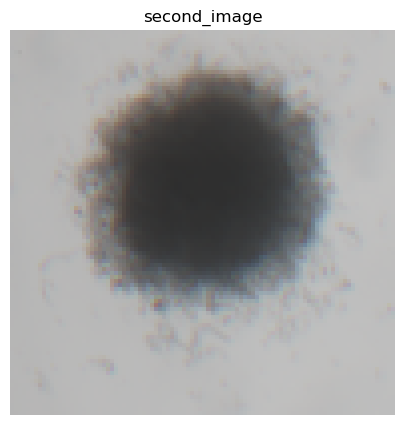

In [71]:
display_image(first_led2, title="second_image")

In [72]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, first_led1_to_model)
second_image_feats = extract_features(simclr_model, first_led2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [73]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.371756374835968


In [ ]:
#second less exploded d1 and d2

In [81]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day7\ds_6.2_gp9_C10-T01.tiff'
second_led1,second_led1_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


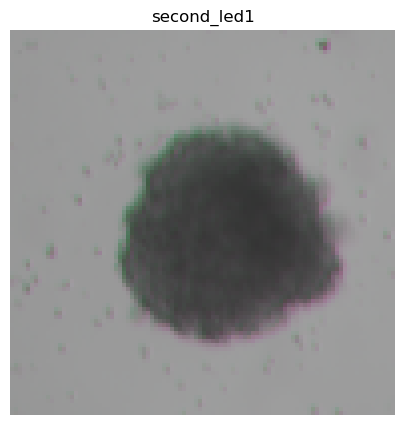

In [82]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_led1, title="second_led1")


In [83]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded40\day10\ds_6.2_gp9_C10-T01.tiff'
second_led2,second_led2_to_model = Preprocess_Image(path_of_image)

torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])


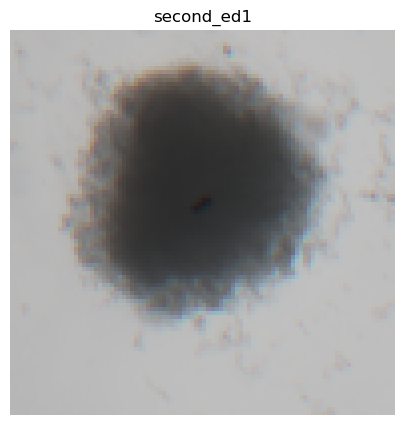

In [84]:
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(second_led2, title="second_ed1")


In [85]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, second_led1_to_model)
second_image_feats = extract_features(simclr_model, second_led2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [86]:
# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.31274306774139404


Inference after projection head

In [23]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [24]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [25]:
# Cosine resize only newdata
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.9717055559158325


In [27]:
# Cosine crop old
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [26]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

torch.Size([1, 20])


In [27]:
# Cosine resize only new data
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: -0.49414071440696716


In [29]:
# Cosine old crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Cosine similarity between features: 0.18768171966075897


as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [48]:
print(first_image)
first_image.view(-1).shape


tensor([[[0.5470, 0.5567, 0.5606,  ..., 0.5938, 0.5943, 0.5934],
         [0.5529, 0.5582, 0.5605,  ..., 0.5936, 0.5938, 0.5925],
         [0.5568, 0.5596, 0.5608,  ..., 0.5942, 0.5940, 0.5944],
         ...,
         [0.5541, 0.5543, 0.5565,  ..., 0.5892, 0.5886, 0.5892],
         [0.5542, 0.5552, 0.5562,  ..., 0.5879, 0.5885, 0.5889],
         [0.5540, 0.5557, 0.5556,  ..., 0.5879, 0.5893, 0.5899]],

        [[0.5493, 0.5567, 0.5601,  ..., 0.5925, 0.5925, 0.5928],
         [0.5534, 0.5577, 0.5596,  ..., 0.5928, 0.5925, 0.5917],
         [0.5566, 0.5582, 0.5598,  ..., 0.5935, 0.5934, 0.5935],
         ...,
         [0.5527, 0.5535, 0.5554,  ..., 0.5882, 0.5880, 0.5887],
         [0.5528, 0.5538, 0.5552,  ..., 0.5873, 0.5875, 0.5885],
         [0.5527, 0.5552, 0.5550,  ..., 0.5877, 0.5885, 0.5891]],

        [[0.5513, 0.5575, 0.5597,  ..., 0.5920, 0.5915, 0.5917],
         [0.5549, 0.5581, 0.5595,  ..., 0.5924, 0.5924, 0.5921],
         [0.5574, 0.5582, 0.5601,  ..., 0.5923, 0.5935, 0.

torch.Size([27648])

In [49]:
print(second_image)
second_image.view(-1).shape

tensor([[[0.5667, 0.5681, 0.5692,  ..., 0.6117, 0.6131, 0.6123],
         [0.5668, 0.5676, 0.5689,  ..., 0.6129, 0.6132, 0.6120],
         [0.5672, 0.5673, 0.5695,  ..., 0.6136, 0.6136, 0.6136],
         ...,
         [0.5707, 0.5719, 0.5733,  ..., 0.6065, 0.6071, 0.6066],
         [0.5709, 0.5718, 0.5733,  ..., 0.6054, 0.6066, 0.6055],
         [0.5712, 0.5710, 0.5731,  ..., 0.6048, 0.6062, 0.6054]],

        [[0.5658, 0.5665, 0.5675,  ..., 0.6108, 0.6114, 0.6110],
         [0.5656, 0.5661, 0.5677,  ..., 0.6119, 0.6123, 0.6115],
         [0.5656, 0.5665, 0.5685,  ..., 0.6126, 0.6120, 0.6122],
         ...,
         [0.5698, 0.5702, 0.5724,  ..., 0.6060, 0.6059, 0.6056],
         [0.5689, 0.5699, 0.5719,  ..., 0.6044, 0.6053, 0.6034],
         [0.5692, 0.5697, 0.5727,  ..., 0.6040, 0.6049, 0.6042]],

        [[0.5648, 0.5659, 0.5666,  ..., 0.6107, 0.6111, 0.6106],
         [0.5654, 0.5659, 0.5673,  ..., 0.6115, 0.6118, 0.6110],
         [0.5651, 0.5663, 0.5677,  ..., 0.6125, 0.6118, 0.

torch.Size([27648])

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [55]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

False

In [42]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

tensor([0.9914])

In [44]:
untreated_flat = untreated_image.view(-1)

In [46]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

tensor([0.9834])

In [50]:
first_flat == untreated_flat

tensor([False, False, False,  ..., False, False, False])

orig without resizing

In [60]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9906225204467773


In [61]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

(3, 2054, 2456)
(15133872,)
Cosine Similarity between the two images: 0.9821854829788208


In [62]:
WAS IST DAS?
Mach kein Sinn!

SyntaxError: invalid syntax (2322824841.py, line 2)

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [72]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 3.129988785460241e-12


In [77]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

Cosine Similarity between the two images: 1.0155029384685969e-13


In [69]:
img1

array([[[34168, 35304, 34600, ..., 39241, 39289, 39033],
        [34168, 35224, 34568, ..., 39225, 38569, 38761],
        [34280, 34984, 35048, ..., 38249, 38249, 39817],
        ...,
        [36792, 35864, 36200, ..., 38009, 36376, 38729],
        [36889, 36504, 36504, ..., 40025, 38297, 38041],
        [36280, 37209, 35656, ..., 37753, 37849, 39897]],

       [[36328, 35848, 34584, ..., 39785, 39609, 38585],
        [35032, 34168, 35944, ..., 39609, 39673, 38201],
        [36392, 35608, 35112, ..., 36953, 39433, 38585],
        ...,
        [35736, 35528, 35240, ..., 39017, 37369, 39017],
        [35144, 35464, 36937, ..., 38697, 38921, 38569],
        [35976, 35752, 35928, ..., 39513, 38921, 37897]],

       [[36680, 35688, 36104, ..., 39977, 39001, 38137],
        [35208, 35848, 35480, ..., 39401, 38681, 37321],
        [35240, 35272, 34856, ..., 37705, 39673, 38265],
        ...,
        [35992, 35560, 34696, ..., 37513, 38393, 38745],
        [35496, 34392, 35272, ..., 37929, 388

In [76]:
img2

array([[[37577, 37369, 36792, ..., 39769, 41050, 39209],
        [37689, 36440, 36873, ..., 39929, 40105, 39881],
        [36728, 37337, 36488, ..., 39097, 40521, 40249],
        ...,
        [37561, 37577, 37449, ..., 38793, 38137, 40297],
        [35784, 38121, 37833, ..., 40025, 39689, 39481],
        [38345, 37065, 38569, ..., 39561, 39497, 39753]],

       [[37321, 37529, 36840, ..., 39881, 39961, 41162],
        [36440, 37049, 37049, ..., 40089, 39321, 40889],
        [36056, 36136, 36376, ..., 38713, 40009, 39321],
        ...,
        [36873, 37625, 38121, ..., 39065, 38425, 39737],
        [36889, 37625, 36328, ..., 39929, 39801, 39033],
        [38233, 37385, 38905, ..., 38953, 38809, 39593]],

       [[36969, 36536, 36536, ..., 41098, 41050, 39577],
        [36680, 36296, 36728, ..., 40073, 40970, 39929],
        [36824, 37353, 37241, ..., 39881, 40249, 40697],
        ...,
        [37449, 37097, 37145, ..., 39177, 38409, 40233],
        [37465, 37993, 37865, ..., 39273, 401

In [75]:
img3

array([[[46155, 46875, 44570, ..., 46283, 45947, 44842],
        [46987, 46747, 45995, ..., 47003, 47467, 46251],
        [45403, 46635, 45915, ..., 45387, 46059, 46059],
        ...,
        [45675, 46555, 44666, ..., 45563, 44538, 47003],
        [46091, 45563, 45851, ..., 47083, 46811, 45435],
        [45131, 45787, 46475, ..., 45995, 45835, 46795]],

       [[46891, 45819, 45979, ..., 46299, 46683, 46507],
        [45371, 45675, 46315, ..., 46427, 45403, 45307],
        [45531, 45307, 45723, ..., 44266, 44858, 45979],
        ...,
        [45707, 45627, 45819, ..., 44538, 44922, 46667],
        [46539, 45611, 45147, ..., 46315, 45755, 45034],
        [45179, 45659, 45851, ..., 46779, 46411, 46011]],

       [[45531, 46171, 45883, ..., 45915, 45579, 46795],
        [46363, 47003, 46331, ..., 46507, 44922, 46507],
        [45531, 45515, 46203, ..., 44554, 45467, 45707],
        ...,
        [45707, 44858, 45451, ..., 45131, 45259, 45691],
        [45787, 47019, 44842, ..., 45819, 453

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random


from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import functional as Func

In [2]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [3]:
full_model_path =  r'C:\Users\k54739\saved_model\simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_10104\485184972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [4]:
from copy import deepcopy
import torchvision.transforms.functional as TF
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))

    print(image.shape)
    image_to_model = image.unsqueeze(0)
    print(image_to_model.shape)
    
    return image,image_to_model


import matplotlib.pyplot as plt

def display_image(image_tensor, title="Image", cmap="gray", figsize=(5, 5)):

    # Convert PyTorch tensor to NumPy array and adjust shape for plotting
    image_np = image_tensor.numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)

    # Display the image
    plt.figure(figsize=figsize)
    plt.imshow(image_np, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Turn off axis for cleaner visualization
    plt.show()


path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\day7\RBT_01.04_B02-T01.tiff'
first_cd1,first_cd1_to_model = Preprocess_Image(path_of_image)

# Example usage
# Assuming `first_image` is a torch.Tensor with shape (C, H, W)
display_image(first_cd1, title="First Image")

pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control29\day10\RBT_01.04_B02-T01.tiff'
first_cd2, first_cd2_to_model = Preprocess_Image(pathimage)

display_image(first_cd2, title="second_image")

# Extract features for both images
first_image_feats = extract_features(simclr_model, first_cd1_to_model)
second_image_feats = extract_features(simclr_model, first_cd2_to_model)
print(first_image_feats.shape)
print(second_image_feats.shape)

# Cosine new data only resize
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

# Specify paths for both day7 and day10 folders
day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\train\day7'
day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\train\day10'

def Preprocess_Image(d7image_dir,d10image_dir, model):
    day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
    day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}
    
    common_files = list(day7_files.keys())
    assert set(common_files) <= set(day10_files.keys()), "Mismatch between day7 and day10 filenames."

    print(len(common_files))

    filename = common_files[idx]
    day7_img_path = day7_files[filename]
    day10_img_path = day10_files[filename]

            # Load the images
    day7_img = tiff.imread(day7_img_path)
    day10_img = tiff.imread(day10_img_path)

            # Ensure the images have 3 layers (channels)
    if day7_img.shape[0] != 3:
        raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
    if day10_img.shape[0] != 3:
        raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

            # Normalize and convert both images
    day7_img = day7_img.astype(np.float32) / 65535.0
    day10_img = day10_img.astype(np.float32) / 65535.0

            # Convert to tensors
    day7_img = torch.tensor(day7_img, dtype=torch.float32)
    day10_img = torch.tensor(day10_img, dtype=torch.float32)
    
    # Resize to (96, 96)
    day7_img = TF.resize(day7_img, (96, 96))
    day10_img = TF.resize(day10_img, (96, 96))

    day7_img_model = day7_img.unsqueeze(0)
    day10_img_model = day10_img.unsqueeze(0)
    

    d7_image_feats = extract_features(simclr_model, day7_img_model)
    d10_image_feats = extract_features(simclr_model, day10_img_model)

    cosine_similarity = nn.functional.cosine_similarity(d7_image_feats, d10_image_feats, dim=1)
    euclidean_distance = euclideandistance

    
    return d7_image_feats, d10_image_feats, cosine_similarity, euclidean_distance


import os
import torch
import numpy as np
import tifffile as tiff
from torchvision.transforms import functional as TF
from torch import nn
from copy import deepcopy

@torch.no_grad()
def Preprocess_Image(day7_dir, day10_dir, model, idx):

    # Collect files from both directories
    day7_files = {os.path.basename(file): os.path.join(day7_dir, file) 
                  for file in os.listdir(day7_dir) if file.endswith(('.tif', '.tiff'))}
    day10_files = {os.path.basename(file): os.path.join(day10_dir, file) 
                   for file in os.listdir(day10_dir) if file.endswith(('.tif', '.tiff'))}
    
    # Find common files
    common_files = list(day7_files.keys())
    assert set(common_files) <= set(day10_files.keys()), "Mismatch between day 7 and day 10 filenames."

    print(f"Number of common files: {len(common_files)}")

    # Select the file at the given index
    filename = common_files[idx]
    day7_img_path = day7_files[filename]
    day10_img_path = day10_files[filename]

    # Load the images
    day7_img = tiff.imread(day7_img_path)
    day10_img = tiff.imread(day10_img_path)

    # Ensure the images have 3 layers (channels)
    if day7_img.shape[0] != 3:
        raise ValueError(f"Day 7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
    if day10_img.shape[0] != 3:
        raise ValueError(f"Day 10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

    # Normalize the images to [0, 1]
    day7_img = day7_img.astype(np.float32) / 65535.0
    day10_img = day10_img.astype(np.float32) / 65535.0

    # Convert to tensors
    day7_img = torch.tensor(day7_img, dtype=torch.float32)
    day10_img = torch.tensor(day10_img, dtype=torch.float32)
    
    # Resize to (96, 96)
    day7_img = TF.resize(day7_img, (96, 96))
    day10_img = TF.resize(day10_img, (96, 96))

    # Add batch dimension
    day7_img_model = day7_img.unsqueeze(0)
    day10_img_model = day10_img.unsqueeze(0)
    
    # Extract features
    d7_image_feats = extract_features(model, day7_img_model)
    d10_image_feats = extract_features(model, day10_img_model)

    # Compute cosine similarity
    cosine_similarity = nn.functional.cosine_similarity(d7_image_feats, d10_image_feats, dim=1)

    # Compute Euclidean distance
    euclidean_distance = torch.norm(d7_image_feats - d10_image_feats, p=2, dim=1)

    return d7_image_feats, d10_image_feats, cosine_similarity, euclidean_distance


In [5]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [6]:
cont_day7 =  r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day7'
cont_day10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\control130_all\combined\day10'

In [7]:
@torch.no_grad()
def Preprocess_All_Images(day7_dir, day10_dir, model):
    """
    Preprocesses all images in the day7 and day10 directories, computes features,
    cosine similarity, and Euclidean distance for each pair.

    Parameters:
    - day7_dir (str): Directory containing day 7 images.
    - day10_dir (str): Directory containing day 10 images.
    - model (torch.nn.Module): The model for feature extraction.

    Returns:
    - results (list of dict): A list containing the results for each image pair, including:
        - filename
        - d7_image_feats
        - d10_image_feats
        - cosine_similarity
        - euclidean_distance
    """
    # Collect files from both directories
    day7_files = {os.path.basename(file): os.path.join(day7_dir, file) 
                  for file in os.listdir(day7_dir) if file.endswith(('.tif', '.tiff'))}
    day10_files = {os.path.basename(file): os.path.join(day10_dir, file) 
                   for file in os.listdir(day10_dir) if file.endswith(('.tif', '.tiff'))}
    
    # Find common files
    common_files = list(day7_files.keys())
    assert set(common_files) <= set(day10_files.keys()), "Mismatch between day 7 and day 10 filenames."

    print(f"Number of common files: {len(common_files)}")

    results = []  # Store results for each image pair

    for filename in common_files:
        # Get file paths
        day7_img_path = day7_files[filename]
        day10_img_path = day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day 7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day 10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize the images to [0, 1]
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        # Resize to (96, 96)
        day7_img = TF.resize(day7_img, (96, 96))
        day10_img = TF.resize(day10_img, (96, 96))

        # Add batch dimension
        day7_img_model = day7_img.unsqueeze(0)
        day10_img_model = day10_img.unsqueeze(0)

        # Extract features
        d7_image_feats = extract_features(model, day7_img_model)
        d10_image_feats = extract_features(model, day10_img_model)

        print(d7_image_feats.shape)

        # Compute cosine similarity
        cosine_similarity = nn.functional.cosine_similarity(d7_image_feats, d10_image_feats, dim=1)

        # Compute Euclidean distance
        euclidean_distance = torch.norm(d7_image_feats - d10_image_feats, p=2, dim=1)
        cosine_distance = 1 - cosine_similarity

        # Append results
        results.append({
            "filename": filename,
            "d7_image_feats": d7_image_feats,
            "d10_image_feats": d10_image_feats,
            "cosine_distance": cosine_distance,
            "euclidean_distance": euclidean_distance
        })

    return results


In [8]:
control_results = Preprocess_All_Images(cont_day7,cont_day10,simclr_model)

Number of common files: 130
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.

In [10]:
# Iterate through the results list
for i, res in enumerate(control_results):
    print(f"Result {i + 1}:")
    print(f"Filename: {res['filename']}")
    print(f"cosine_distance: {res['cosine_distance'].item():.4f}")
    print(f"Euclidean Distance: {res['euclidean_distance'].item():.4f}")
    #print(f"Day 7 Features: {res['d7_image_feats']}")
    #print(f"Day 10 Features: {res['d10_image_feats']}")


Result 1:
Filename: RBTDS1B_D07-T01.tiff
cosine_distance: 0.6376
Euclidean Distance: 60.1851
Result 2:
Filename: RBTDS1B_D08-T01.tiff
cosine_distance: 0.6795
Euclidean Distance: 70.4498
Result 3:
Filename: RBTDS1B_D09-T01.tiff
cosine_distance: 0.7240
Euclidean Distance: 61.1272
Result 4:
Filename: RBTDS1B_D10-T01.tiff
cosine_distance: 0.7243
Euclidean Distance: 55.5564
Result 5:
Filename: RBTDS1B_D11-T01.tiff
cosine_distance: 0.6625
Euclidean Distance: 50.3518
Result 6:
Filename: RBTDS1B_E07-T01.tiff
cosine_distance: 0.7216
Euclidean Distance: 69.3081
Result 7:
Filename: RBTDS1B_E08-T01.tiff
cosine_distance: 0.6665
Euclidean Distance: 63.1861
Result 8:
Filename: RBTDS1B_E09-T01.tiff
cosine_distance: 0.7168
Euclidean Distance: 50.7611
Result 9:
Filename: RBTDS1B_E10-T01.tiff
cosine_distance: 0.6772
Euclidean Distance: 66.1552
Result 10:
Filename: RBTDS1B_E11-T01.tiff
cosine_distance: 0.7075
Euclidean Distance: 66.7069
Result 11:
Filename: RBTDS1B_F07-T01.tiff
cosine_distance: 0.7024
Euc

In [11]:
exp_day7= r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day7'
exp_day10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\exploded38\day10'

In [12]:
exp_results = Preprocess_All_Images(exp_day7,exp_day10,simclr_model)

Number of common files: 38
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [13]:
# Iterate through the results list
for i, res in enumerate(exp_results):
    print(f"Result {i + 1}:")
    print(f"Filename: {res['filename']}")
    print(f"cosine_distance: {res['cosine_distance'].item():.4f}")
    print(f"Euclidean Distance: {res['euclidean_distance'].item():.4f}")


Result 1:
Filename: ds_1b_gp9_C10.tiff
cosine_distance: 0.7104
Euclidean Distance: 53.7645
Result 2:
Filename: ds_1b_gp9_C11.tiff
cosine_distance: 0.7323
Euclidean Distance: 55.7929
Result 3:
Filename: ds_1b_gp9_C7.tiff
cosine_distance: 0.7254
Euclidean Distance: 61.1816
Result 4:
Filename: ds_1b_gp9_C8.tiff
cosine_distance: 0.7209
Euclidean Distance: 60.7437
Result 5:
Filename: ds_1b_gp9_C9.tiff
cosine_distance: 0.7678
Euclidean Distance: 66.9353
Result 6:
Filename: ds_4.1_gp3_C02-T01.tiff
cosine_distance: 0.6688
Euclidean Distance: 38.4301
Result 7:
Filename: ds_4.1_gp3_C03-T01.tiff
cosine_distance: 0.7037
Euclidean Distance: 33.2638
Result 8:
Filename: ds_4.1_gp3_C04-T01.tiff
cosine_distance: 0.5927
Euclidean Distance: 32.5994
Result 9:
Filename: ds_4.1_gp3_C05-T01.tiff
cosine_distance: 0.7449
Euclidean Distance: 40.3062
Result 10:
Filename: ds_4.1_gp3_C06-T01.tiff
cosine_distance: 0.5865
Euclidean Distance: 31.5217
Result 11:
Filename: ds_6.1_gp3_C03-T01.tiff
cosine_distance: 0.670

In [14]:
less_exp_day7= r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\less_exp2\day7'
less_exp_day10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\less_exp2\day10'

In [15]:
less_exp_results = Preprocess_All_Images(less_exp_day7,less_exp_day10,simclr_model)

Number of common files: 2
torch.Size([1, 512])
torch.Size([1, 512])


In [16]:
# Iterate through the results list
for i, res in enumerate(less_exp_results):
    print(f"Result {i + 1}:")
    print(f"Filename: {res['filename']}")
    print(f"cosine_distance: {res['cosine_distance'].item():.4f}")
    print(f"Euclidean Distance: {res['euclidean_distance'].item():.4f}")


Result 1:
Filename: ds_6.2_gp9_C09-T01.tiff
cosine_distance: 0.6282
Euclidean Distance: 31.7877
Result 2:
Filename: ds_6.2_gp9_C10-T01.tiff
cosine_distance: 0.6873
Euclidean Distance: 38.6379


In [17]:
sd_day7= r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\Before (untreated) Day7\GANT61'
sd_day10 = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\sd_ds\single_dose\RBT 01.04_gant61\After Day10\GANT61'

In [18]:
sd_results = Preprocess_All_Images(sd_day7,sd_day10,simclr_model)

Number of common files: 29
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [19]:
# Iterate through the results list
for i, res in enumerate(sd_results):
    print(f"Result {i + 1}:")
    print(f"Filename: {res['filename']}")
    print(f"cosine_distance: {res['cosine_distance'].item():.4f}")
    print(f"Euclidean Distance: {res['euclidean_distance'].item():.4f}")


Result 1:
Filename: B07-T01.tiff
cosine_distance: 0.6342
Euclidean Distance: 32.8473
Result 2:
Filename: B08-T01.tiff
cosine_distance: 0.7057
Euclidean Distance: 44.5317
Result 3:
Filename: B09-T01.tiff
cosine_distance: 0.6515
Euclidean Distance: 28.8045
Result 4:
Filename: B10-T01.tiff
cosine_distance: 0.7006
Euclidean Distance: 44.5426
Result 5:
Filename: B11-T01.tiff
cosine_distance: 0.6350
Euclidean Distance: 52.5606
Result 6:
Filename: C07-T01.tiff
cosine_distance: 0.5851
Euclidean Distance: 24.9901
Result 7:
Filename: C08-T01.tiff
cosine_distance: 0.5875
Euclidean Distance: 25.6173
Result 8:
Filename: C09-T01.tiff
cosine_distance: 0.6693
Euclidean Distance: 39.1737
Result 9:
Filename: C10-T01.tiff
cosine_distance: 0.6529
Euclidean Distance: 59.9391
Result 10:
Filename: D07-T01.tiff
cosine_distance: 0.5005
Euclidean Distance: 24.6487
Result 11:
Filename: D08-T01.tiff
cosine_distance: 0.6258
Euclidean Distance: 28.3726
Result 12:
Filename: D09-T01.tiff
cosine_distance: 0.5728
Eucli

In [28]:
# Extract distances from the results
cont_cosine = [res["cosine_distance"].item() for res in control_results]
print(len(cont_cosine))
cont_euclidean = [res["euclidean_distance"].item() for res in control_results]

sd_cosine = [res["cosine_distance"].item() for res in sd_results]
print(len(sd_cosine))
sd_euclidean = [res["euclidean_distance"].item() for res in sd_results]

ex_cosine = [res["cosine_distance"].item() for res in exp_results]
ex_euclidean = [res["euclidean_distance"].item() for res in exp_results]
print(len(ex_cosine))

less_ex_cosine = [res["cosine_distance"].item() for res in less_exp_results]
less_ex_euclidean = [res["euclidean_distance"].item() for res in less_exp_results]
print(len(less_ex_cosine))

130
29
38
2


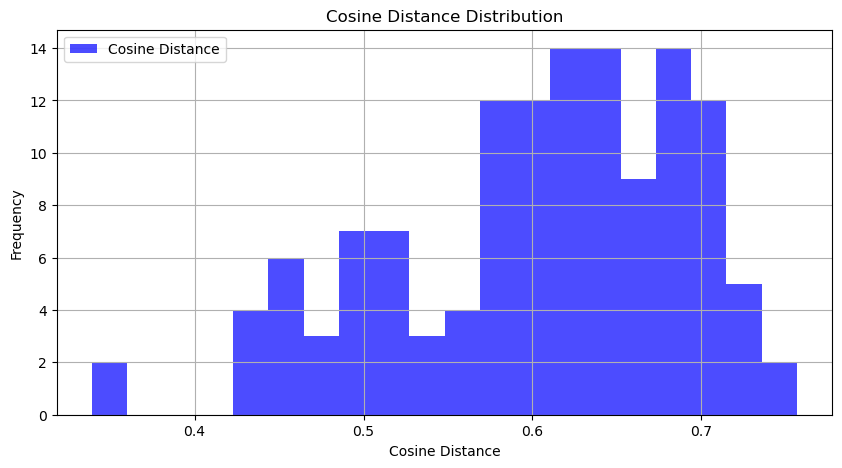

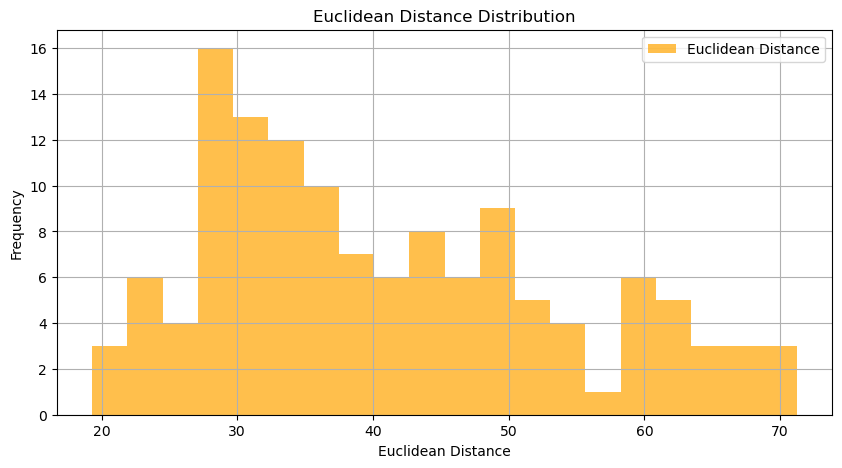

In [30]:
import matplotlib.pyplot as plt

# Plot the distribution of Cosine Distance
plt.figure(figsize=(10, 5))
plt.hist(cont_cosine, bins=20, color='blue', alpha=0.7, label='Cosine Distance')
plt.title('Cosine Distance Distribution')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Plot the distribution of Euclidean Distance
plt.figure(figsize=(10, 5))
plt.hist(cont_euclidean, bins=20, color='orange', alpha=0.7, label='Euclidean Distance')
plt.title('Euclidean Distance Distribution')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


In [31]:
# Extract distances from the results
cont_cosine = [res["cosine_distance"].item() for res in control_results]
print(len(cont_cosine))
cont_euclidean = [res["euclidean_distance"].item() for res in control_results]

sd_cosine = [res["cosine_distance"].item() for res in sd_results]
print(len(sd_cosine))
sd_euclidean = [res["euclidean_distance"].item() for res in sd_results]

ex_cosine = [res["cosine_distance"].item() for res in exp_results]
ex_euclidean = [res["euclidean_distance"].item() for res in exp_results]
print(len(ex_cosine))

less_ex_cosine = [res["cosine_distance"].item() for res in less_exp_results]
less_ex_euclidean = [res["euclidean_distance"].item() for res in less_exp_results]
print(len(less_ex_cosine))

130
29
38
2


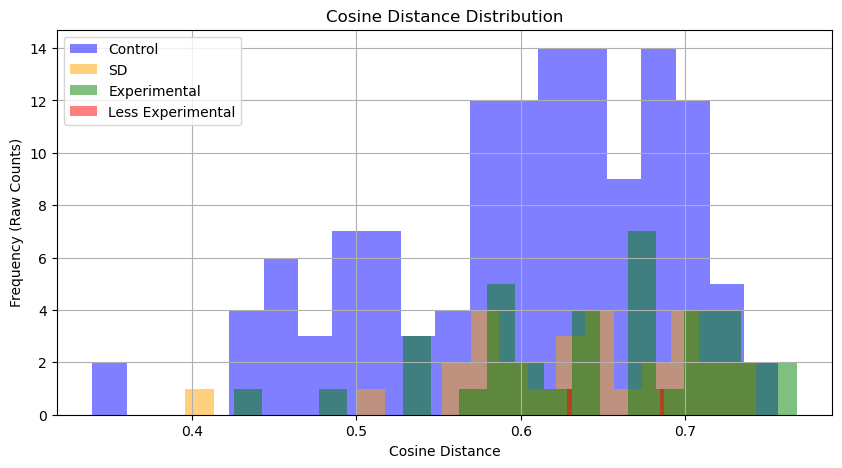

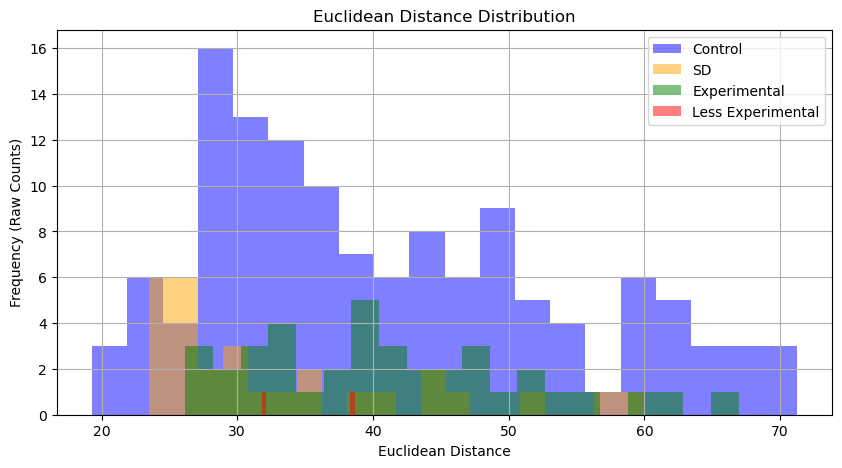

In [33]:
import matplotlib.pyplot as plt

# Define colors and labels for the groups
groups = {
    "Control": cont_cosine,
    "SD": sd_cosine,
    "Experimental": ex_cosine,
    "Less Experimental": less_ex_cosine
}
colors = ["blue", "orange", "green", "red"]

# Plot Cosine Distances
plt.figure(figsize=(10, 5))
for (label, data), color in zip(groups.items(), colors):
    plt.hist(data, bins=20, alpha=0.5, label=label, color=color)  # No density=True
plt.title("Cosine Distance Distribution")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency (Raw Counts)")
plt.legend()
plt.grid()
plt.show()

# Update groups for Euclidean distances
groups = {
    "Control": cont_euclidean,
    "SD": sd_euclidean,
    "Experimental": ex_euclidean,
    "Less Experimental": less_ex_euclidean
}

# Plot Euclidean Distances
plt.figure(figsize=(10, 5))
for (label, data), color in zip(groups.items(), colors):
    plt.hist(data, bins=20, alpha=0.5, label=label, color=color)  # No density=True
plt.title("Euclidean Distance Distribution")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency (Raw Counts)")
plt.legend()
plt.grid()
plt.show()
